## Código para testar o modelo de YOLO

---

In [79]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import cv2
from paddleocr import PaddleOCR
import os
import regex as re
import requests

In [15]:
def classify_image(image_path):    
    model = YOLO('last.pt')  
    results = model(image_path)
    
    # Display results
    for result in results:
        img_rgb = cv2.cvtColor(result.plot(show=False), cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(10, 10))
        plt.imshow(img_rgb)
        plt.axis('off')
        plt.show()

def classify_and_crop(image_path):
    # Load model
    model = YOLO('last.pt')
    
    # Run inference
    results = model(image_path)
    
    # Read the original image
    original_image = cv2.imread(image_path)
    imgnames = []


    # Iterate over results
    for i, result in enumerate(results):
        boxes = result.boxes.xyxy.cpu().numpy()  # Get bounding boxes in (x1, y1, x2, y2) format

        for j, (x1, y1, x2, y2) in enumerate(boxes):
            # Convert coordinates to integers
            x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])

            # Crop the image
            cropped = original_image[y1:y2, x1:x2]

            # Convert BGR to RGB for displaying
            cropped_rgb = cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB)
            # Save the cropped image
            output_filename = f'cropped_{i}_{j}.png'
            imgnames.append(output_filename)
            cv2.imwrite(output_filename, cropped)

            # Show the cropped region
            plt.figure(figsize=(4, 4))
            plt.imshow(cropped_rgb)
            plt.axis('off')
            plt.title(f'Cropped #{i}-{j}')
            plt.show()
    return imgnames

In [71]:
def change_char_in_position(word, position):
    # Change the character at the specified position to a letter
    if position < len(word):
        if word[position].isdigit():
            digit = word[position]
            # Se for 8 troca por B, se for 1 troca por I
            if digit == '8':
                word = word[:position] + 'B' + word[position+1:]
            elif digit == '1':
                word = word[:position] + 'I' + word[position+1:]
    return word

ocr = PaddleOCR(use_angle_cls=True, lang='en', show_log=False)

def extract_plate_from_image(image_path):
    # Load model
    result = ocr.ocr(image_path, cls=True)
    
    is_new_plate = False
    
    detected_words = []
    for line in result:
        for word_info in line:
            if word_info[1][0].lower() == "brasil":
                is_new_plate = True
            else:
                detected_words.append((word_info[1][0], word_info[1][1]))
                
                
    print(f"É nova placa? {is_new_plate}")    
    for word_tuple in detected_words:
        word = word_tuple[0]
        confidence = word_tuple[1]                
            
        # Deve ter o formato "XXX9999" ou "XXX9X99"
        print(f"Detected text: {word}")
        
        if (re.match(r'^[A-Z]{3}\d{4}$', word) and not is_new_plate) or re.match(r'^[A-Z]{3}\d{1}[A-Z]\d{2}$', word):
            return word
        
        else:
            # Try to fix plate text: characters 0,1,2 must be letters.
            if word[0].isdigit():
                word = change_char_in_position(word, 0)
            if word[1].isdigit():
                word = change_char_in_position(word, 1)
            if word[2].isdigit():
                word = change_char_in_position(word, 2)
            if is_new_plate and word[4].isdigit():
                word = change_char_in_position(word, 4)
                            
            if re.match(r'^[A-Z]{3}\d{4}$', word) or re.match(r'^[A-Z]{3}\d{1}[A-Z]\d{2}$', word):
                print(f"Valid plate: {word}, Confidence: {confidence:.2f}")
                return word
            
    return None
                    
        
                    
                        
                    
    


image 1/1 /home/louis/Documents/7/compvis/compvis-car/carro2.jpeg: 480x640 2 License_Plates, 221.3ms
Speed: 2.1ms preprocess, 221.3ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


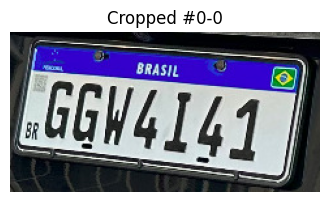

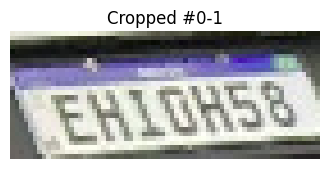

In [84]:
image_path = 'carro2.jpeg'
imgs = classify_and_crop(image_path)

In [85]:
plates = []
for img in imgs:
    plate = extract_plate_from_image(img)
    if plate:
        plates.append(plate)

É nova placa? True
Detected text: GGW4141
Valid plate: GGW4I41, Confidence: 0.97
É nova placa? False
Detected text: EHIOH58



image 1/1 /home/louis/Documents/7/compvis/compvis-car/estacionamento.jpg: 640x480 3 License_Plates, 236.9ms
Speed: 2.0ms preprocess, 236.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


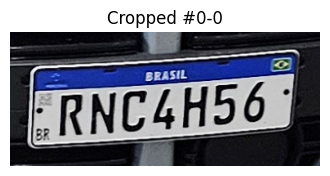

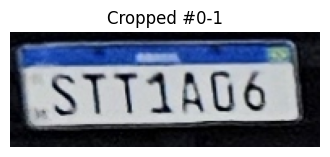

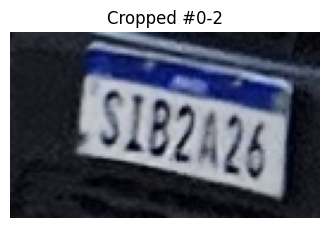

In [86]:
image_path = 'estacionamento.jpg'
imgs = classify_and_crop(image_path)

In [87]:
plates = []
for img in imgs:
    print(f"Processing image: {img}")
    plate = extract_plate_from_image(img)
    if plate:
        plates.append(plate)
    print('-'*20)


Processing image: cropped_0_0.png
É nova placa? True
Detected text: RNC4H56
--------------------
Processing image: cropped_0_1.png
É nova placa? False
Detected text: STT1A06
--------------------
Processing image: cropped_0_2.png
É nova placa? False
Detected text: S182A26
Valid plate: SIB2A26, Confidence: 0.88
--------------------


In [ ]:
api_url = 'https://wdapi2.com.br/consulta/{placa}/{token}'

placa = plates[0]
token = 'xxaxa'
response = requests.get(api_url.format(placa=placa, token=token))
if response.status_code == 200:
    data = response.json()
    print(f"API Response: {data}")

API Response: {'MARCA': 'T', 'MODELO': 'BMW M3 COMPETITION', 'SUBMODELO': 'BMW', 'VERSAO': 'COMPETITION', 'ano': '2021', 'anoModelo': '2021', 'chassi': '*****98928', 'codigoSituacao': '0', 'cor': 'Cinza', 'data': '24/04/2025 13:49:53', 'extra': {'ano_fabricacao': '2021', 'ano_modelo': '2021', 'caixa_cambio': '', 'cap_maxima_tracao': '210', 'carroceria': '', 'chassi': 'WBS31AY0XMFK98928', 'cilindradas': '2993', 'combustivel': 'Gasolina', 'di': '2108129803', 'eixo_traseiro_dif': '', 'eixos': '2', 'especie': 'Passageiro', 'faturado': '00416863000144', 'grupo': None, 'limite_restricao_trib': '', 'linha': '106416748', 'media_preco': None, 'modelo': None, 'motor': '', 'municipio': 'BELO HORIZONTE', 'nacionalidade': 'Importado', 'peso_bruto_total': '221', 'placa': 'RNC4H56', 'placa_modelo_antigo': 'RNC4756', 'placa_modelo_novo': 'RNC4H56', 'quantidade_passageiro': '5', 'registro_di': '', 'renavam': '', 'restricao_1': 'ALIENACAO FIDUCIARIA', 'restricao_2': 'SEM RESTRICAO', 'restricao_3': 'SEM 

In [ ]:
modelo = data['modelo']
marca = data['marca']
ano = data['ano']
fipe = data['fipe']

{'dados': [{'ano_modelo': '2021',
   'codigo_fipe': '009234-7',
   'codigo_marca': 7,
   'codigo_modelo': '8439',
   'combustivel': 'Gasolina',
   'id_valor': 1369442,
   'mes_referencia': 'abril de 2025',
   'referencia_fipe': 320,
   'score': 82,
   'sigla_combustivel': 'G',
   'texto_marca': 'BMW',
   'texto_modelo': 'M2 Competition 3.0 Bi-Turbo 410cv Aut.',
   'texto_valor': 'R$ 464.847,00',
   'tipo_modelo': 1},
  {'ano_modelo': '2021',
   'codigo_fipe': '009268-1',
   'codigo_marca': 7,
   'codigo_modelo': '9103',
   'combustivel': 'Gasolina',
   'id_valor': 1369444,
   'mes_referencia': 'abril de 2025',
   'referencia_fipe': 320,
   'score': 76,
   'sigla_combustivel': 'G',
   'texto_marca': 'BMW',
   'texto_modelo': 'M2 Competition Ed. Espe. 3.0 Bi-TB Mec.',
   'texto_valor': 'R$ 531.799,00',
   'tipo_modelo': 1},
  {'ano_modelo': '2021',
   'codigo_fipe': '009280-0',
   'codigo_marca': 7,
   'codigo_modelo': '9482',
   'combustivel': 'Gasolina',
   'id_valor': 1369473,
   'mes